# New York Times News Summarization
Sirut Buasai, sbausai2@wpi.edu <br>
Jason Dykstra, jpdykstra@wpi.edu <br>
Adam Yang ayang@wpi.edu
## Libraries

In [ ]:
# Data Processing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv

# Text Processing
import nltk
import re
import spacy
from nltk.corpus import stopwords
from nltk import pos_tag_sents

# Model Building
import tensorflow as tf
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Metrics
!pip install sacrebleu
!pip install rouge
from sacrebleu import sentence_bleu
from rouge import Rouge

# Google Colab
from google.colab import drive, files
drive.mount('/content/gdrive')

# Downloads
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
NER = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Global Variables

In [ ]:
MAX_ABSTRACT_LEN = 30
MAX_TITLE_LEN = 12
LATENT_DIMENSION = 300 
EMBEDDING_DIMENSION = 100 
EPOCH = 10
BATCH_SIZE = 128
DATA_SET_RATIO = 0.8
MODEL_CONDITION = "cleaned_abstract"

## Data Pre-processing
### Initial Data Inspection

In [ ]:
# download and make initial inspection of the dataset
raw_data_path = 'NYT_Dataset.csv'
raw_data = pd.read_csv(raw_data_path)
raw_data = raw_data[:int(DATA_SET_RATIO*len(raw_data))]
print(f'dataframe shape: {raw_data.shape}')
raw_data

dataframe shape: (85204, 7)


,Unnamed: 0,ID,title,topic,abstract,Date,keywords
0,0,nyt://article/178801fe-4679-5f12-985f-8344a86e...,"In Reversal, Pakistan Welcomes Outside Help Wi...",Foreign,Pakistan’s ambassador to the U.S. said his gov...,2008-01-01 05:00:00+00:00,['Assassinations and Attempted Assassinations'...
1,1,nyt://article/21acedcb-a7f6-5131-99cf-d3a47e33...,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew ...",2008-01-01 05:00:00+00:00,"['Kenya', 'Demonstrations and Riots', 'Odinga,..."
2,2,nyt://article/357b5429-a9f8-5d33-a5eb-c013a201...,Israel: Olmert Curbs Settlements,Foreign,Prime Minister Ehud Olmert has sent a letter t...,2008-01-01 05:00:00+00:00,['West Bank']
3,3,nyt://article/619ca4ea-50e4-59e4-97bb-f206502c...,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an ...,2008-01-01 05:00:00+00:00,"['Homosexuality', 'Islam', 'IMMIGRATION AND RE..."
4,4,nyt://article/73c49a5a-bcf1-5b8f-a15a-98d29003...,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, ...",2008-01-01 05:00:00+00:00,"['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"
...,...,...,...,...,...,...,...
85199,85199,nyt://article/28b6a869-bb20-51f5-92f1-d3189a0d...,‘Snowflakes’ and ‘Me Me Me Millennials’ Asked ...,Foreign,A new ad campaign suggests that what is seen a...,2019-01-04 16:59:50+00:00,"['Great Britain', 'Defense and Military Forces..."
85200,85200,nyt://article/a7f7637d-9bd1-518d-a3c9-deda4b0c...,Toxic Peroxide Found on Dutch Beach After Carg...,Foreign,The Netherlands deployed troops to help clean ...,2019-01-04 18:11:34+00:00,"['Maritime Accidents and Safety', 'Ships and S..."
85201,85201,nyt://article/2e64ae57-4c98-56e6-a7af-a7d5c6b6...,"She’s on a #MeToo Mission in China, Battling C...",Foreign,Zhou Xiaoxuan is fighting China’s patriarchal ...,2019-01-04 18:32:05+00:00,"['China', 'Zhou Xiaoxuan', 'Zhu Jun', '#MeToo ..."
85202,85202,nyt://article/2ad87a17-18f6-5fb7-93ed-09e8a7a5...,Kansas Senator Pat Roberts Will Not Seek Re-el...,Politics,Mr. Roberts became the second long-serving Rep...,2019-01-04 20:11:44+00:00,"['Elections, Senate', 'Roberts, Pat', 'Republi..."


### Clean Data
#### Part of Speech Processing Function

In [ ]:
# Parts-of-Speech processing to filter and keep certain POS words
def pos_processing(abstract_sentences):
    # split the sentence into tokens
    abstract_tokens = pd.Series(abstract_sentences.apply(lambda sentence: sentence.split()))

    # identify parts-of-speech; pos_tag requires list of tokens
    abstract_pos = pd.Series(pos_tag_sents(abstract_tokens))

    # filter non-desirable parts-of-speech
    nounsList = ['NN', 'NNS', 'NNP', 'NNPS'] # Nouns
    verbsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VPZ'] # Verbs
    adjList = ['JJ', 'JJR', 'JJS'] # Adjectives
    pos_list = nounsList + verbsList + adjList
    abstract_pos_filtered = abstract_pos.apply(lambda words: ' '.join([pair[0] for pair in words if pair[1] in pos_list]))

    return abstract_pos_filtered

#### NER Processing Function

In [ ]:
# NER function to identify and embed NER tags
def ner_processing(abstract_sentences):
  # identify entities for each abstract
  abs_entities = pd.Series(abstract_sentences.apply(lambda sentence: NER(sentence)))

  # extract the original sentences, but now with split contractions and the entity type from NER
  original_sentence = pd.Series(abs_entities.apply(lambda entities: ' '.join([f"{token.orth_}<{token.ent_type_}>" if token.ent_type_ else f"{token.orth_}" for token in entities])))

  return original_sentence

#### Clean Text Function

In [ ]:
# Main preprocessing function
def preprocess_data(df):
    # drop unnecessary columns
    unused_columns = ['Unnamed: 0', 'Date', 'ID']
    df.drop(unused_columns, axis=1, inplace=True, errors='ignore')

    # drop duplicates and nan rows
    df.drop_duplicates(subset=['abstract'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # convert texts to lowercase
    df['abstract'] = df['abstract'].str.lower()
    df['title'] = df['title'].str.lower()
    df['keywords'] = df['keywords'].str.lower()
    df['topic'] = df['topic'].str.lower()

    # strip special characters
    df['cleaned_title'] = df['title'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
    df['cleaned_abstract'] = df['abstract'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
    df['cleaned_keywords'] = df['keywords'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
    df['cleaned_topic'] = df['topic'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))

    # add keywords and topics
    df['cleaned_keywords'] = df['cleaned_keywords'].apply(lambda sentence: "".join(word for word in sentence))
    df['cleaned_abstract_keywords'] = df['cleaned_abstract'] + df['cleaned_keywords'] + ' ' + df['topic']

    # convert string to list
    df['cleaned_title'] = df['cleaned_title'].apply(lambda text: text.split())
    df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda text: text.split())
    df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda text: text.split())

    # remove stopwords
    stop_words = stopwords.words('english')
    df['cleaned_title'] = df['cleaned_title'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])
    df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])
    df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])

    # convert list back to string
    df['cleaned_title'] = df['cleaned_title'].apply(lambda sentence: " ".join(word for word in sentence))
    df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda sentence: " ".join(word for word in sentence))
    df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda sentence: " ".join(word for word in sentence))

    # filter and keep noun, verbs, and adj words; requires string sentences
    df['cleaned_abstract_pos'] = pos_processing(df['cleaned_abstract'])
    df['cleaned_abstract_pos_keywords'] = pos_processing(df['cleaned_abstract_keywords'])

    # identify named-entities; NER requires string sentences
    df['cleaned_title'] = ner_processing(df['cleaned_title'])
    df['cleaned_abstract_pos_ner'] = ner_processing(df['cleaned_abstract_pos'])
    df['cleaned_abstract_pos_keywords_ner'] = ner_processing(df['cleaned_abstract_pos_keywords'])

    # add start and end tokens for title
    df['cleaned_title'] = df['cleaned_title'].apply(lambda text: 'sostok ' + text + ' eostok')

    # drop unnecessary columns
    unnecessary_columns = ['topic', 'keywords', 'cleaned_keywords', 'cleaned_topic', 'cleaned_abstract_keywords']
    df.drop(unnecessary_columns, axis=1, inplace=True, errors='ignore')

    # important columns are cleaned_title, cleaned_abstract, cleaned_abstract_pos_ner, cleaned_abstract_pos_keywords_ner
    return df

# cleaned_data = preprocess_data(raw_data)
cleaned_data = pd.read_csv("cleaned_data.csv")
print(f'dataframe shape: {cleaned_data.shape}')
cleaned_data

dataframe shape: (84605, 9)


,Unnamed: 0,title,abstract,cleaned_title,cleaned_abstract,cleaned_abstract_pos,cleaned_abstract_pos_keywords,cleaned_abstract_pos_ner,cleaned_abstract_pos_keywords_ner
0,0,"in reversal, pakistan welcomes outside help wi...",pakistan’s ambassador to the u.s. said his gov...,sostok reversal pakistan<GPE> welcomes outside...,pakistans ambassador us said government would ...,pakistans ambassador said government endorse s...,pakistans ambassador said government endorse s...,pakistans<NORP> ambassador said government end...,pakistans<NORP> ambassador said government end...
1,1,fighting intensifies after election in kenya,"kenya sank deeper into trouble, with a curfew ...",sostok fighting intensifies election kenya<GPE...,kenya sank deeper trouble curfew imposed kisum...,kenya sank trouble curfew imposed kisumu count...,kenya sank trouble curfew imposed kisumu count...,kenya<PERSON> sank trouble curfew imposed kisu...,kenya<PERSON> sank trouble curfew imposed kisu...
2,2,israel: olmert curbs settlements,prime minister ehud olmert has sent a letter t...,sostok israel<GPE> olmert<PERSON> curbs settle...,prime minister ehud olmert sent letter defense...,prime minister ehud olmert sent letter defense...,prime minister ehud olmert sent letter defense...,prime minister ehud<PERSON> olmert<PERSON> sen...,prime minister ehud<PERSON> olmert<PERSON> sen...
3,3,gay muslims pack a dance floor of their own,the monthly club night known as gayhane is an ...,sostok gay muslims<NORP> pack dance floor eostok,monthly club night known gayhane alltoorare op...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...
4,4,iraqi revelers embrace the new year,"but even as partygoers embraced the new year, ...",sostok iraqi<NORP> revelers embrace new<DATE> ...,even partygoers embraced new year surge attack...,partygoers embraced new year surge attacks mon...,partygoers embraced new year surge attacks mon...,partygoers embraced new year<DATE> surge attac...,partygoers embraced new year<DATE> surge attac...
...,...,...,...,...,...,...,...,...,...
84600,84600,‘snowflakes’ and ‘me me me millennials’ asked ...,a new ad campaign suggests that what is seen a...,sostok snowflakes millennials asked join ranks...,new ad campaign suggests seen weakness charact...,new ad campaign seen weakness character flaw r...,new ad campaign seen weakness character flaw r...,new ad campaign seen weakness character flaw r...,new ad campaign seen weakness character flaw r...
84601,84601,toxic peroxide found on dutch beach after carg...,the netherlands deployed troops to help clean ...,sostok toxic peroxide found dutch<NORP> beach ...,netherlands deployed troops help clean storm t...,netherlands deployed troops help clean storm t...,netherlands deployed troops help clean storm t...,netherlands<GPE> deployed troops help clean st...,netherlands<GPE> deployed troops help clean st...
84602,84602,"she’s on a #metoo mission in china, battling c...",zhou xiaoxuan is fighting china’s patriarchal ...,sostok she s metoo mission china<GPE> battling...,zhou xiaoxuan fighting chinas patriarchal cult...,zhou xiaoxuan fighting chinas patriarchal cult...,zhou xiaoxuan fighting chinas patriarchal cult...,zhou<PERSON> xiaoxuan<PERSON> fighting chinas<...,zhou<PERSON> xiaoxuan<PERSON> fighting chinas<...
84603,84603,kansas senator pat roberts will not seek re-el...,mr. roberts became the second long-serving rep...,sostok kansas<GPE> senator pat<PERSON> roberts...,mr roberts became second longserving republica...,mr roberts became second longserving republica...,mr roberts became second longserving republica...,mr roberts became second<ORDINAL> longserving ...,mr roberts became second<ORDINAL> longserving ...


In [ ]:
# print first five rows to check results
for i in range(5):
  print("Abstract:\n\t", cleaned_data['abstract'][i])
  print("Title:\n\t", cleaned_data['title'][i])
  print("\n")
  print("Cleaned Abstract:\n\t", cleaned_data['cleaned_abstract'][i])
  print("Cleaned Abstract with POS:\n\t", cleaned_data['cleaned_abstract_pos'][i])
  print("Cleaned Abstract with POS and Keywords:\n\t", cleaned_data['cleaned_abstract_pos_keywords'][i])
  print("Cleaned Abstract with POS and NER:\n\t", cleaned_data['cleaned_abstract_pos_ner'][i])
  print("Cleaned Abstract with POS and Keywords and NER:\n\t", cleaned_data['cleaned_abstract_pos_keywords_ner'][i])
  print("Cleaned Title:\n\t", cleaned_data['cleaned_title'][i])
  print("\n")

Abstract:
	 pakistan’s ambassador to the u.s. said his government would not endorse a separate inquiry modeled after one carried out by the u.n. after the assassination of rafik hariri of lebanon in 2005.
Title:
	 in reversal, pakistan welcomes outside help with  inquiry on bhutto


Cleaned Abstract:
	 pakistans ambassador us said government would endorse separate inquiry modeled one carried un assassination rafik hariri lebanon 2005
Cleaned Abstract with POS:
	 pakistans ambassador said government endorse separate inquiry modeled carried un assassination rafik hariri lebanon
Cleaned Abstract with POS and Keywords:
	 pakistans ambassador said government endorse separate inquiry modeled carried un assassination rafik hariri lebanon attempted assassinations pakistan bhutto benazir federal bureau investigation united nations foreign
Cleaned Abstract with POS and NER:
	 pakistans<NORP> ambassador said government endorse separate inquiry modeled carried un<ORG> assassination rafik hariri le

### Insepct String Length Distribution

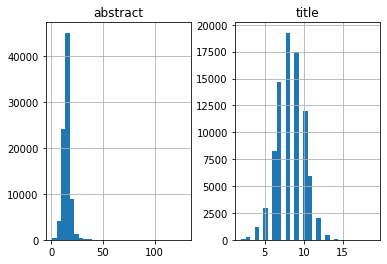

In [ ]:
abstract_word_count = []
title_word_count = []


# Convert cleaned_abstract to all strings
cleaned_data['cleaned_abstract'] = cleaned_data['cleaned_abstract'].astype(str)
cleaned_data['cleaned_abstract_pos'] = cleaned_data['cleaned_abstract_pos'].astype(str)


# populate the lists with sentence lengths
for i in cleaned_data['cleaned_abstract']:
  abstract_word_count.append(len(i.split()))

for i in cleaned_data['cleaned_title']:
  title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'abstract':abstract_word_count, 'title':title_word_count})

length_df.hist(bins = 30)
plt.show()

### Split Training and Testing Set

In [ ]:
# split the dataset into training and testing sets
abs_tr, abs_te, ttl_tr, ttl_te = train_test_split(
  np.array(cleaned_data[MODEL_CONDITION]),
  np.array(cleaned_data['cleaned_title']),
  test_size=0.1,
  random_state=10,
  shuffle=True)

### Tokenize Title and Abstracts

In [ ]:
# Function to tokenize the datasets
def tokenize_text(train_set, test_set, string_length, rare_word_threshold):
  # find the number of rarewords
  tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_{|}~\t\n') # filters prevent NER tag to be separated
  tokenizer.fit_on_texts(list(train_set))
  rare_word_count = 0
  total_word_count = 0
  for _,freq in tokenizer.word_counts.items():
    total_word_count = total_word_count + 1
    if (freq < rare_word_threshold):
      rare_word_count += 1
    
  # prepare a tokenizer for reviews on training data
  tokenizer = Tokenizer(num_words=total_word_count-rare_word_count, filters='!"#$%&()*+,-./:;=?@[\\]^_{|}~\t\n') # filters prevent NER tag to be separated
  tokenizer.fit_on_texts(list(train_set))

  # convert text sequences into integer sequences
  train_set = tokenizer.texts_to_sequences(train_set) 
  test_set = tokenizer.texts_to_sequences(test_set)

  # padding zero up to maximum length
  train_set = pad_sequences(train_set, maxlen=string_length, padding='post') 
  test_set = pad_sequences(test_set, maxlen=string_length, padding='post')

  # get vector size
  vocab_size = tokenizer.num_words+1

  return tokenizer, train_set, test_set, vocab_size

abs_tokenizer, abs_tr, abs_te, abs_size = tokenize_text(abs_tr, abs_te, MAX_ABSTRACT_LEN, 3)
ttl_tokenizer, ttl_tr, ttl_te, ttl_size = tokenize_text(ttl_tr, ttl_te, MAX_TITLE_LEN, 6)

### Remove Empty Texts

In [ ]:
# Function for removing strings with no text
def remove_empty_text(abstract, title):
    indices = []
    for i in range(len(ttl_tr)):
        cnt = 0
        for j in ttl_tr[i]:
            if j!=0:
                cnt=cnt+1
        if (cnt == 2):
            indices.append(i)

    abstract = np.delete(abs_tr, indices, axis=0)
    title = np.delete(ttl_tr, indices, axis=0)
    print(f"removed {len(indices)} empty texts.")

    return abstract, title

abs_tr, ttl_tr = remove_empty_text(abs_tr, ttl_tr)
abs_te, ttl_te = remove_empty_text(abs_te, ttl_te)

removed 205 empty texts.
removed 0 empty texts.


## Build LSTM Model

In [ ]:
tf.keras.backend.clear_session() 

# input layer
encoder_inputs = tf.keras.layers.Input(shape=(MAX_ABSTRACT_LEN,))

# embedding layer
enc_emb =  tf.keras.layers.Embedding(abs_size, 
                                     EMBEDDING_DIMENSION, 
                                     trainable=True)(encoder_inputs)

# encoder lstm 1
encoder_lstm1 = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                     return_sequences=True, 
                                     return_state=True, 
                                     dropout=0.4, 
                                     recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = tf.keras.layers.LSTM(LATENT_DIMENSION,
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4,
                                     recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm 3
encoder_lstm3 = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                     return_state=True, 
                                     return_sequences=True,
                                     dropout=0.4,
                                     recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# set up the decoder, using `encoder_states` as initial state.
decoder_inputs = tf.keras.layers.Input(shape=(None,))

# embedding layer
dec_emb_layer = tf.keras.layers.Embedding(ttl_size, 
                                          EMBEDDING_DIMENSION, 
                                          trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder lstm
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                    return_sequences=True, 
                                    return_state=True,
                                    dropout=0.4,
                                    recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,
                                                                     initial_state=[state_h, state_c])

# attention layer
attn_layer = tf.keras.layers.AdditiveAttention()
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# concat attention input and decoder LSTM output
decoder_concat_input = tf.keras.layers.Concatenate()([decoder_outputs, attn_out])

# dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ttl_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# define the model 
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      2253800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

### Train the Model

In [ ]:
# initialize model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# train model
history = model.fit([abs_tr, ttl_tr[:,:-1]], ttl_tr.reshape(ttl_tr.shape[0], ttl_tr.shape[1], 1)[:,1:],
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=([abs_te,ttl_te[:,:-1]], ttl_te.reshape(ttl_te.shape[0], ttl_te.shape[1], 1)[:,1:]))



Epoch 1/10
594/594 [==============================] - 303s 495ms/step - loss: 4.3323 - val_loss: 4.0856
Epoch 2/10
594/594 [==============================] - 292s 492ms/step - loss: 4.0193 - val_loss: 3.8724
Epoch 3/10
594/594 [==============================] - 292s 492ms/step - loss: 3.8466 - val_loss: 3.7059
Epoch 4/10
594/594 [==============================] - 293s 494ms/step - loss: 3.7171 - val_loss: 3.5676
Epoch 5/10
594/594 [==============================] - 291s 490ms/step - loss: 3.6186 - val_loss: 3.4631
Epoch 6/10
594/594 [==============================] - 291s 489ms/step - loss: 3.5382 - val_loss: 3.3788
Epoch 7/10
594/594 [==============================] - 290s 488ms/step - loss: 3.4684 - val_loss: 3.3085
Epoch 8/10
594/594 [==============================] - 288s 486ms/step - loss: 3.4073 - val_loss: 3.2377
Epoch 9/10
594/594 [==============================] - 289s 486ms/step - loss: 3.3567 - val_loss: 3.1753
Epoch 10/10
594/594 [==============================] - 289s 487m

### Inspect Training Validation Loss

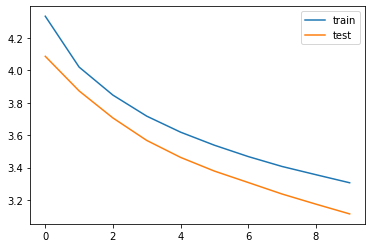

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Vec2Word Dictionary

In [ ]:
# grab the dictionaries to convert token ids back to string texts
reverse_target_word_index = ttl_tokenizer.index_word 
reverse_source_word_index = abs_tokenizer.index_word 
target_word_index = ttl_tokenizer.word_index

## Build Inference Model

In [ ]:
# encode the input sequence to get the feature vector
encoder_model = tf.keras.models.Model(inputs=encoder_inputs,
                                      outputs=[encoder_outputs, state_h, state_c])

# decoder setup
# below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(LATENT_DIMENSION,))
decoder_state_input_c = tf.keras.layers.Input(shape=(LATENT_DIMENSION,))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(MAX_ABSTRACT_LEN, LATENT_DIMENSION))

# get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# to predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = tf.keras.layers.Concatenate()([decoder_outputs2, attn_out_inf])

# a dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# final decoder model
decoder_model = tf.keras.models.Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                                      [decoder_outputs2] + [state_h2, state_c2])

### Decode Inference Output Function

In [ ]:
# Function to decode the output of the decoder model
def decode_sequence(input_seq):
    # encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    # generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    # loop through the decoder model's outputs and build the output sentence
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        # grab decoder model output tokens and internal states
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        
        # convert token back to associated string text
        try:
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_word_index[sampled_token_index]
        except KeyError:
          stop_condition = True

        # remove NER tag if necessary
        sampled_token = re.sub('<[^>]+>', '', sampled_token)

        # if the token is not the end token, then add token to the output sentence
        if (sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token

        # exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (MAX_TITLE_LEN-1)):
            stop_condition = True

        # update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # update internal states
        e_h, e_c = h, c

    return decoded_sentence

### Seq2Abstract and Seq2Title Function

In [ ]:
# Convert the abstract token id sequence back to string representation
def seq2abstract(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

# Convert the title token id sequence back to string representation
def seq2title(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sostok']) and (i != target_word_index['eostok']):
            newString = newString + re.sub('<[^>]+>', '', reverse_target_word_index[i]) + ' '
    return newString

## Testing Model
### BLEU and ROUGE Evaluation Function

In [ ]:
rouge_metric = Rouge()

# Evaluation Metric Function; F1 Score with ROUGE and BLEU
def evaluate_title(predicted_ttl, original_ttl):
    # Note: prediction and original titles both need to be string sentences
    # get BLEU score
    bleu_result = (sentence_bleu(hypothesis=predicted_ttl, references=[original_ttl], smooth_method='exp'))
    bleu_score = bleu_result.score/100 # sacreBLEU gives the score in percent

    # get ROUGE score
    rouge_result = rouge_metric.get_scores(hyps=predicted_ttl, refs=original_ttl)
    rouge_score = rouge_result[0]["rouge-l"]["f"]

    # check if either score is 0
    if (bleu_score == 0.0) or (rouge_score == 0.0):
        # if so, score is 0
        return 0.0

    # get overall F1 score
    return (2.0 * bleu_score * rouge_score) / (bleu_score + rouge_score)


### Print Predictions

In [ ]:
# Keep track of total F1 score to average at the end
total_f1 = 0

# results_df = pd.DataFrame()
# results_df['original_abstract'] = abs_te.tolist()
# results_df['original_title'] = ttl_te.tolist()
# results_df['original_title'] = results_df['original_title'].apply(lambda row: seq2title(row))
# results_df['predicted_title'] = results_df['original_abstract'].apply(lambda row: decode_sequence(np.array(row).reshape(1, MAX_ABSTRACT_LEN)))
# results_df['f1_scores'] = results_df.apply(lambda row: evaluate_title(row['predicted_title'], row['original_title']), axis=1)


# Loop over all test set data and calculate F1 score for each prediction
for i in range(1000):
  if i % 10 == 0: print(f"i = {i}")
  
  
  original_title = seq2title(ttl_te[i])
  
  
  prediction_title = decode_sequence(abs_te[i].reshape(1, MAX_ABSTRACT_LEN))

  # Skip bad predictions
  if prediction_title == "" or prediction_title == None: 
    print("Skipping bad prediction...")
    continue

  

  # Generate F1 score for current prediction
  f1_score = evaluate_title(prediction_title, original_title)

  # Add to total F1
  total_f1 += f1_score

  if i <= 10:
    print("Abstract:", seq2abstract(abs_te[i]))
    print("Original Title:", original_title)
    print("Predicted Title:", prediction_title)
    print("F1 Score:", f1_score)
    print("\n")


# results_df.to_csv("outputs/results.csv")
avg_f1 = total_f1 / 1000

  # Write individual predictions to csv
  # flag = "a"
  # if not os.path.exists(f"output/{MODEL_CONDITION}.csv"): flag = "w"
      
  # with open(f"output/{MODEL_CONDITION}.csv", flag) as csv_file:
  #     csv_writer = csv.writer(csv_file)
  #     if flag == "w": csv_writer.writerow(["F1 Score", "Original Title", "Predicted Title"])
  #     csv_writer.writerow([f1_score, original_title, prediction_title])

# Find average F1 score for entire test set (total/len)
# avg_f1 = total_f1/len(abs_te)
print(f"Average F1 score: {avg_f1}")

# Write results to csv
flag = "a"
if not os.path.exists("output/model_data.csv"): flag = "w"
    
with open("output/model_data.csv", flag) as csv_file:
    csv_writer = csv.writer(csv_file)
    if flag == "w": csv_writer.writerow(["Model Type", "Model Condition", "Average F1 Score"])
    csv_writer.writerow(["LSTM", MODEL_CONDITION, avg_f1])


# Google colab code
# Download files
# files.download("output/model_data.csv")
# files.download(f"output/{MODEL_CONDITION}.csv")


i = 0
Abstract: mr fujimori president 1990 2000 serving 25year term human rights abuses 
Original Title: perus president pardons fujimori critics 
Predicted Title:  former president dies 77
F1 Score: 0.15950955761799962


Abstract: chris christie mike huckabee appeared onstage first time republican candidates bobby jindal rick santorum undercard debate tuesday leading candidates took stage 
Original Title: gop debate 
Predicted Title:  chris christie chris christie
F1 Score: 0.0


Abstract: victory andalusia spanish conservatives would deal another blow socialists ousting longstanding regional stronghold 
Original Title: looks ready overturn socialist power 
Predicted Title:  turkeys voters seek new term
F1 Score: 0.0


Abstract: conservative anglicans say see possibility reconciliation episcopal church us anglican church canada accepted gay bishop samesex unions 
Original Title: conservative anglicans plan rival conference split homosexuality grows 
Predicted Title:  ireland gay marri

FileNotFoundError: ignored

In [ ]:
cleaned_data.to_csv("output/cleaned_data.csv")